## Import TensorFlow and other libraries

In [1]:
import outils
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
df = outils.Load_data.load_object("dataset2.zip")

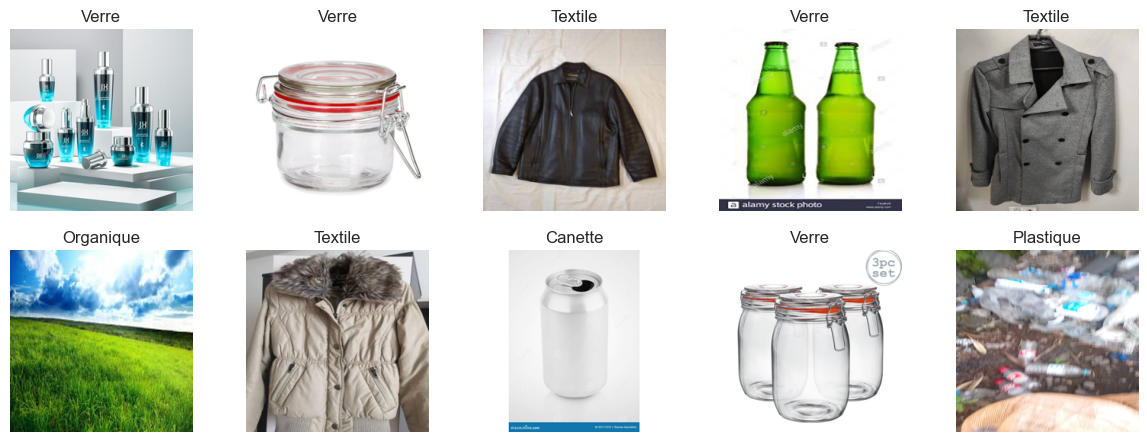

In [3]:
df.plot()

In [4]:
df.encodage()

In [5]:
(X_train,_),( X_test , _) = df.create_data(test_size=0.5)

In [6]:
X_test = X_test[1:20]

In [7]:
print(f"X_train shape : {X_train.shape}")

X_train shape : (6069, 240, 240, 3)


In [8]:
X_train = X_train.astype('float32') / 255.

In [9]:
X_test = X_test.astype('float32') / 255.

In [10]:
X_test.max()

np.float32(1.0)

In [8]:
#noise_adder = outils.NoiseAdder(X_train)

In [10]:
#noisy_gaussian = noise_adder.apply("gaussian", std=0.2)

In [10]:
print(f"min = {np.min(X_test)} et max = {np.max(X_test)}")

min = 0.0 et max = 1.0


In [11]:
print(f"min = {np.min(X_train)} et max = {np.max(X_train)}")

min = 0.0 et max = 1.0


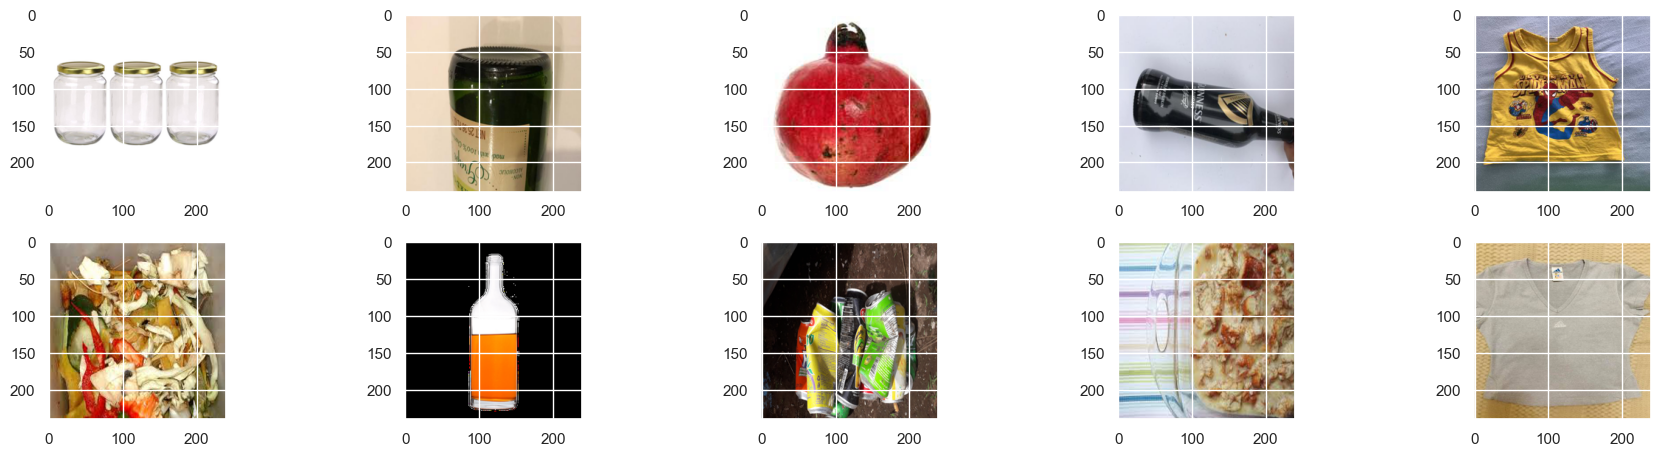

In [12]:
plt.figure(figsize=(18,9))
for i in range(1,11):
    plt.subplot(4,5,i)
    plt.imshow(X_train[i])
    #plt.title(y_train[i])
    plt.tight_layout()
plt.show()

In [13]:
import os 
import numpy as np
import tensorflow as tf 
from tensorflow.keras import layers, models, losses, callbacks, regularizers
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau

In [14]:
from keras.saving import register_keras_serializable

In [ ]:
def ResidualBlock(filters, stride=1, use_bn=True, l2=1e-4):
    def f(x):
        shortcut = x
        y = layers.Conv2D(filters, 3, strides=stride, padding="same",
                          kernel_regularizer=tf.keras.regularizers.l2(l2), use_bias=not use_bn)(x)
        if use_bn: y = layers.BatchNormalization()(y)
        y = layers.Activation("relu")(y)

        y = layers.Conv2D(filters, 3, padding="same",
                          kernel_regularizer=tf.keras.regularizers.l2(l2), use_bias=not use_bn)(y)
        if use_bn: y = layers.BatchNormalization()(y)

        # Adapter raccourci
        if shortcut.shape[-1] != filters or stride != 1:
            shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same",
                                     kernel_regularizer=tf.keras.regularizers.l2(l2),
                                     use_bias=not use_bn)(shortcut)
            if use_bn: shortcut = layers.BatchNormalization()(shortcut)

        out = layers.Add()([y, shortcut])
        out = layers.Activation("relu")(out)
        return out
    return f


# -----------------------------
# Bloc résiduel upsampling
# -----------------------------
def ResidualBlockUp(filters, scale=2, use_bn=True, l2=1e-4):
    def f(x):
        shortcut = x
        y = layers.UpSampling2D(size=(scale, scale))(x)
        y = layers.Conv2D(filters, 3, padding="same",
                          kernel_regularizer=tf.keras.regularizers.l2(l2), use_bias=not use_bn)(y)
        if use_bn: y = layers.BatchNormalization()(y)
        y = layers.Activation("relu")(y)

        y = layers.Conv2D(filters, 3, padding="same",
                          kernel_regularizer=tf.keras.regularizers.l2(l2), use_bias=not use_bn)(y)
        if use_bn: y = layers.BatchNormalization()(y)

        shortcut = layers.UpSampling2D(size=(scale, scale))(shortcut)
        shortcut = layers.Conv2D(filters, 1, padding="same",
                                 kernel_regularizer=tf.keras.regularizers.l2(l2),
                                 use_bias=not use_bn)(shortcut)
        if use_bn: shortcut = layers.BatchNormalization()(shortcut)

        out = layers.Add()([y, shortcut])
        out = layers.Activation("relu")(out)
        return out
    return f


# -----------------------------
def build_encoder(input_shape=(64, 64, 3), latent_dim=256, base=32):
    inp = layers.Input(shape=input_shape)
    x = inp
    x = layers.Conv2D(base, 3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = ResidualBlock(base, stride=1)(x)
    x = ResidualBlock(base*2, stride=2)(x)
    x = ResidualBlock(base*2, stride=1)(x)
    x = ResidualBlock(base*4, stride=2)(x)
    x = ResidualBlock(base*4, stride=1)(x)
    x = ResidualBlock(base*8, stride=2)(x)
    x = ResidualBlock(base*8, stride=1)(x)
    x = layers.GlobalAveragePooling2D()(x)
    z = layers.Dense(latent_dim, name="z")(x)  # Une seule sortie
    return tf.keras.Model(inp, z, name="encoder_classic")

def build_decoder(output_shape=(64, 64, 3), latent_dim=256, base=32):
    H, W, C = output_shape
    h0, w0 = H // 8, W // 8
    inp = layers.Input(shape=(latent_dim,))
    x = layers.Dense(h0 * w0 * base*8, activation="relu")(inp)
    x = layers.Reshape((h0, w0, base*8))(x)
    x = ResidualBlock(base*8, stride=1)(x)
    x = ResidualBlockUp(base*4)(x)
    x = ResidualBlock(base*4, stride=1)(x)
    x = ResidualBlockUp(base*2)(x)
    x = ResidualBlock(base*2, stride=1)(x)
    x = ResidualBlockUp(base)(x)
    x = ResidualBlock(base, stride=1)(x)
    out = layers.Conv2D(C, 3, padding="same", activation="sigmoid")(x)
    return tf.keras.Model(inp, out, name="decoder_classic")


# -----------------------------
# Callback pour affichage reconstruction
# -----------------------------
class PlotReconstructionCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, x_vis):
        super().__init__()
        self.vae_model = model
        self.x_vis = x_vis#.astype("float32") / 255.0  # normalisation ici

    def on_epoch_end(self, epoch, logs=None):
        z_mean, z_logvar, z = self.vae_model.encoder.predict(self.x_vis)
        recon = self.vae_model.decoder.predict(z)
        n = min(5, len(self.x_vis))
        plt.figure(figsize=(20, 8))
        for i in range(n):
            plt.subplot(2, n, i + 1)
            plt.imshow(np.clip(self.x_vis[i], 0, 1))
            plt.axis("off")
            plt.title("Original")

            plt.subplot(2, n, n + i + 1)
            plt.imshow(np.clip(recon[i], 0, 1))
            plt.axis("off")
            plt.title("Reconstruit")
        plt.suptitle(f"Époque {epoch + 1}")
        plt.tight_layout()
        plt.show()

@register_keras_serializable()
class Autoencoder(tf.keras.Model):
    def __init__(
        self, 
        encoder, 
        decoder, 
        add_noise=True,
        noise_std=0.05,
        dropout_rate=0.05,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        self.add_noise = add_noise
        self.noise_std = noise_std
        self.dropout_rate = dropout_rate

        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    # Pour la sérialisation Keras
    def get_config(self):
        config = super().get_config()
        config.update({
            "add_noise": self.add_noise,
            "noise_std": self.noise_std,
            "dropout_rate": self.dropout_rate,
            "encoder": tf.keras.utils.serialize_keras_object(self.encoder),
            "decoder": tf.keras.utils.serialize_keras_object(self.decoder),
        })
        return config

    @classmethod
    def from_config(cls, config):
        encoder = tf.keras.utils.deserialize_keras_object(config.pop("encoder"))
        decoder = tf.keras.utils.deserialize_keras_object(config.pop("decoder"))
        return cls(encoder=encoder, decoder=decoder, **config)

    @property
    def metrics(self):
        return [self.loss_tracker] 

    # ------------------------
    # Fonction pour ajouter du bruit
    # ------------------------
    def add_training_noise(self, x):
        if not self.add_noise:
            return x

        # Bruit gaussien
        x_noisy = x + tf.random.normal(
            shape=tf.shape(x),
            mean=0.0,
            stddev=self.noise_std
        )

        # Dropout (optionnel)
        if self.dropout_rate > 0.0:
            x_noisy = tf.nn.dropout(x_noisy, rate=self.dropout_rate)

        # Clamp entre 0–1
        x_noisy = tf.clip_by_value(x_noisy, 0.0, 1.0)

        return x_noisy

    # ------------------------
    # TRAIN STEP
    # ------------------------
    def train_step(self, data):
        if isinstance(data, (tuple, list)) and len(data) >= 2:
            x_original = data[0]  # Images originales (cibles)
            x_original = tf.cast(x_original, tf.float32)
        else:
            x_original = tf.cast(data, tf.float32)
        
        # Version bruitée/augmentée (entrée du modèle)
        x_noisy = self.add_training_noise(x_original)
        
        with tf.GradientTape() as tape:
            # Encodage
            z = self.encoder(x_noisy, training=True)
            
            # Décodage
            x_recon = self.decoder(z, training=True)
            
            # Loss MSE entre reconstruction et image originale (propre)
            loss = tf.reduce_mean(tf.square(x_original - x_recon))
        
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Mise à jour de la métrique
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}

    # ------------------------
    # TEST STEP
    # ------------------------
    def test_step(self, data):
        if isinstance(data, (tuple, list)):
            x = data[0]
        else:
            x = data
        
        x = tf.cast(x, tf.float32)
        
        # Encodage
        z = self.encoder(x, training=False)
        
        # Décodage
        x_recon = self.decoder(z, training=False)
        
        # Loss
        loss = tf.reduce_mean(tf.square(x - x_recon))
        
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}

    # ------------------------
    # Pour l'inférence
    # ------------------------
    def call(self, x):
        z = self.encoder(x, training=False)
        return self.decoder(z, training=False)

    # ------------------------
    # Pour la détection d'anomalies
    # ------------------------
    def compute_anomaly_score(self, x):
        """
        Calcule le score d'anomalie basé sur l'erreur de reconstruction.
        """
        x_recon = self(x, training=False)
        mse = tf.reduce_mean(tf.square(x - x_recon), axis=[1, 2, 3])
        return mse

    def train(
        self, x_train, x_val=None, batch_size=32, epochs=100, x_vis=None, save_path="residual_vae.keras"
    ):
        self.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4))

        callbacks_list = [
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=80, restore_best_weights=True
            ),
            tf.keras.callbacks.ModelCheckpoint(save_path,monitor="recon_loss",verbose=1,save_best_only=True,mode="auto"),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss", factor=0.5, patience=10, verbose=1, min_lr=1e-7
            ),
        ]

        if x_vis is not None:
            callbacks_list.append(PlotReconstructionCallback(self, x_vis))

        history = self.fit(
            x_train, x_train,
            validation_data=(x_val, x_val) if x_val is not None else None,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks_list,
            shuffle=True,
        )
        return history



In [ ]:
input_shape = (240, 240, 3)   # adapter à vos images
latent_dim  = 128

encoder = build_encoder(input_shape=input_shape, latent_dim=latent_dim, base=16)
decoder = build_decoder(output_shape=input_shape, latent_dim=latent_dim, base=8)
autoencoder = Autoencoder(
    encoder,
    decoder,
   
    add_noise=True,
    noise_std=0.15,    # plus fort
    dropout_rate=0.05  # masque 5% des pixels
)


In [17]:
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 240, 240, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 240, 240, 16)      │             448 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 240, 240, 16)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 240, 240, 16)      │           2,304 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 240, 240, 16)      │              64 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 240, 240, 16)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 240, 240, 16)      │           2,304 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 240, 240, 16)      │              64 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 240, 240, 16)      │               0 │ batch_normalization_1[0][… │
│                               │                           │                 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 240, 240, 16)      │               0 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 120, 120, 32)      │           4,608 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 120, 120, 32)      │             128 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 120, 120, 32)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 120, 120, 32)      │           9,216 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 120, 120, 32)      │             512 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 796,608 (3.04 MB)

 Trainable params: 794,304 (3.03 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [18]:
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 128)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 57600)             │       7,430,400 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 30, 30, 64)        │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_18 (Conv2D)            │ (None, 30, 30, 64)        │          36,864 │ reshape[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_17        │ (None, 30, 30, 64)        │             256 │ conv2d_18[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_15 (Activation)    │ (None, 30, 30, 64)        │               0 │ batch_normalization_17[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_19 (Conv2D)            │ (None, 30, 30, 64)        │          36,864 │ activation_15[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_18        │ (None, 30, 30, 64)        │             256 │ conv2d_19[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_7 (Add)                   │ (None, 30, 30, 64)        │               0 │ batch_normalization_18[0]… │
│                               │                           │                 │ reshape[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_16 (Activation)    │ (None, 30, 30, 64)        │               0 │ add_7[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d (UpSampling2D)  │ (None, 60, 60, 64)        │               0 │ activation_16[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_20 (Conv2D)            │ (None, 60, 60, 32)        │          18,432 │ up_sampling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_19        │ (None, 60, 60, 32)        │             128 │ conv2d_20[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_17 (Activation)    │ (None, 60, 60, 32)        │               0 │ batch_normalization_19[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_1               │ (None, 60, 60, 64)        │               0 │ activation_16[0][0]        │
│ (UpSampling2D)                │                           │               

 Total params: 7,569,147 (28.87 MB)

 Trainable params: 7,568,331 (28.87 MB)

 Non-trainable params: 816 (3.19 KB)

In [19]:
import matplotlib.pyplot as plt

def plot_result(history, metrics=None, name_fig="fig", register=False):
    # Dictionnaire contenant toutes les métriques
    hist = history.history  

    # Si metrics n’est pas fourni, on prend toutes les clés
    if metrics is None:
        metrics = [m for m in hist.keys() if not m.startswith("val_")]

    n = len(metrics)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 5))

    if n == 1:
        axes = [axes]  # uniformiser

    for i, metric in enumerate(metrics):
        ax = axes[i]
        ax.plot(hist[metric], label=f"Train {metric}")
        if f"val_{metric}" in hist:
            ax.plot(hist[f"val_{metric}"], label=f"Val {metric}")
        ax.set_title(metric.capitalize())
        ax.set_xlabel("Epochs")
        ax.set_ylabel(metric)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    if register:
        plt.savefig(f"{name_fig}.png")
    plt.show()

In [9]:
from tensorflow.keras.models import load_model

In [10]:
model = load_model("model_dct_6.keras", custom_objects={"ResidualVAE": ResidualVAE, "Sampling": Sampling})

C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 116 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Compiler et entraîner le modèle avec visualisation
import time
start_time = time.time()
history = autoencoder.train(
    x_train = X_train,
    x_val=X_test, 
    batch_size=128,
    epochs=100,
    x_vis=X_test, 
    save_path="model_dct_7.keras"
)
end_time = time.time()
elapsed = end_time - start_time
days, rem = divmod(elapsed, 86400)          
hours, rem = divmod(rem, 3600)
minutes, seconds = divmod(rem, 60)

print(f"Temps d'entraînement : {int(days)}j {int(hours):02d}h {int(minutes):02d}m {int(seconds):02d}s")

autoencoder.save("model_dct_7.keras")
plot_result(history,name_fig="outo-loss",register=True)

Epoch 1/100


In [15]:
from tensorflow.keras.models import load_model

In [11]:
base_model = load_model("model_cls_14.keras")

In [12]:
decoder = model.get_layer("decoder")  


✅ Total trainable params: 82,432
Discriminator - last layers trainable:
batch_normalization_2 False
max_pooling2d_2 False
conv2d_3 False
batch_normalization_3 False
max_pooling2d_3 False
conv2d_4 True
batch_normalization_4 True
max_pooling2d_4 True
global_average_pooling2d True
disc_dense_1 True
disc_dense_2 True
disc_output True
Generator - last layers trainable:
z_input True
dense_10 True
dense_11 True
style_vector True
decoder True


In [29]:
encoded_imgs,g,z = model.encoder(img)

C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_2']
Received: inputs=Tensor(shape=(11, 240, 240, 3))
  warnings.warn(msg)


In [20]:
g

<tf.Tensor: shape=(11, 128), dtype=float32, numpy=
array([[-10.731409 , -10.530298 , -10.4178915, ...,  -9.859847 ,
        -10.954012 , -10.228492 ],
       [ -9.1078415,  -8.55936  ,  -8.887307 , ...,  -8.528783 ,
         -8.814857 ,  -8.933781 ],
       [ -7.456779 ,  -7.714625 ,  -7.6416435, ...,  -7.3960023,
         -8.308933 ,  -8.005684 ],
       ...,
       [ -9.701587 ,  -9.726039 ,  -9.744497 , ...,  -9.251593 ,
         -9.964143 ,  -9.489742 ],
       [ -8.636517 ,  -8.657707 ,  -8.376025 , ...,  -8.372363 ,
         -8.359367 ,  -8.306711 ],
       [ -9.645868 , -10.035462 , -10.328987 , ...,  -9.426003 ,
         -9.991358 , -10.012485 ]], dtype=float32)>

In [38]:
pred = model.decoder(encoded_imgs)

NameError: name 'encoded_imgs' is not defined

In [23]:
pred.shape[0]

11

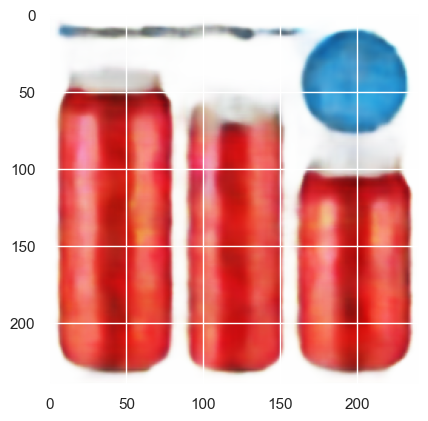

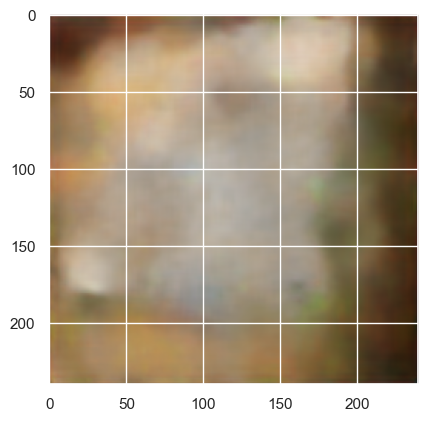

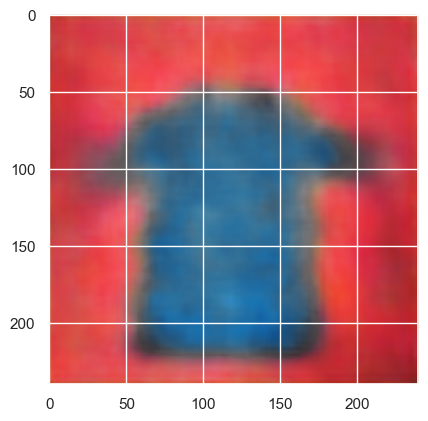

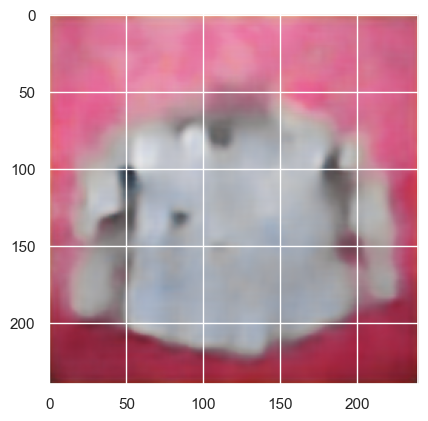

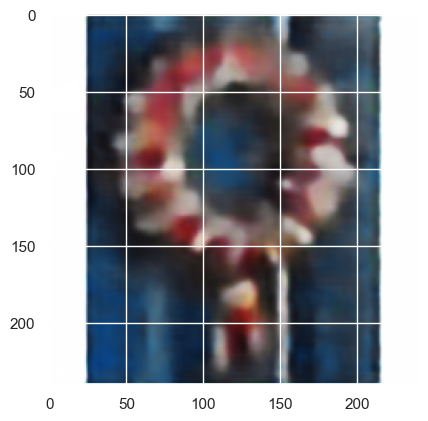

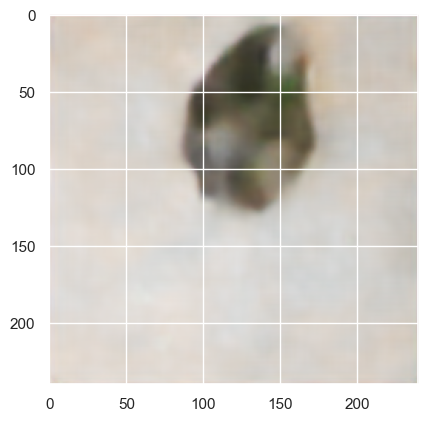

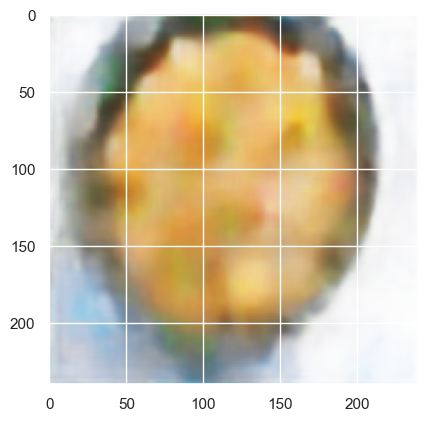

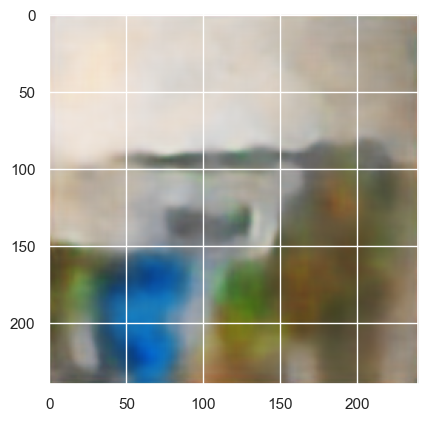

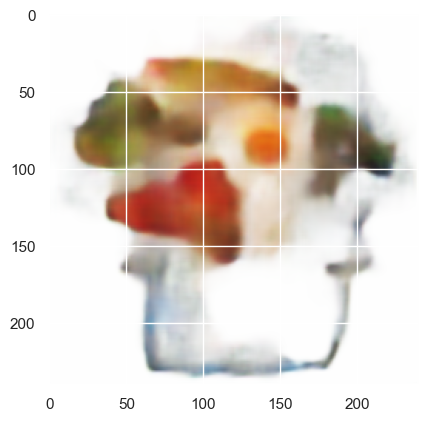

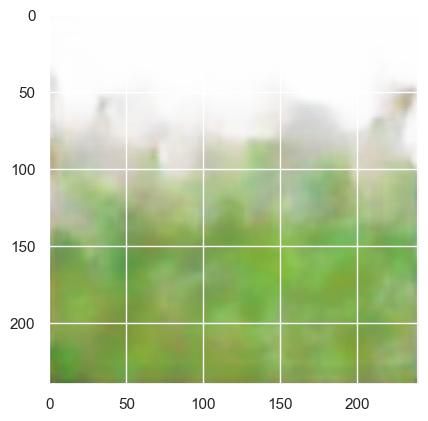

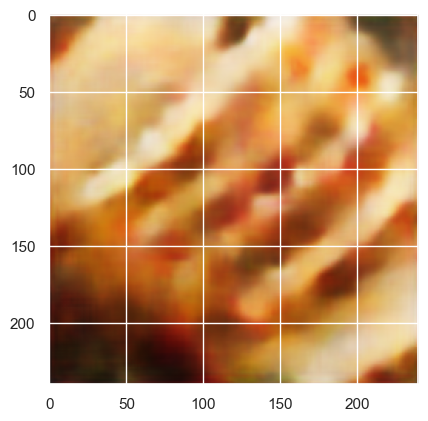

In [31]:
for i in range(pred.shape[0]):
    plt.imshow(np.clip(pred[i], 0, 1))
    plt.show()

In [30]:
def normalize_image(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val + 1e-8)


In [32]:
def on_epoch_end(model, img):
        z_mean, z_logvar, z = model.encoder.predict(img)
        recon = model.decoder.predict(z)
        n = min(5, len(img))
        plt.figure(figsize=(20, 8))
        for i in range(n):
            plt.subplot(2, n, i + 1)
            plt.imshow(np.clip(img[i], 0, 1))
            plt.axis("off")
            plt.title("Original")

            plt.subplot(2, n, n + i + 1)
            plt.imshow(np.clip(recon[i], 0, 1))
            plt.axis("off")
            plt.title("Reconstruit")
        plt.tight_layout()
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


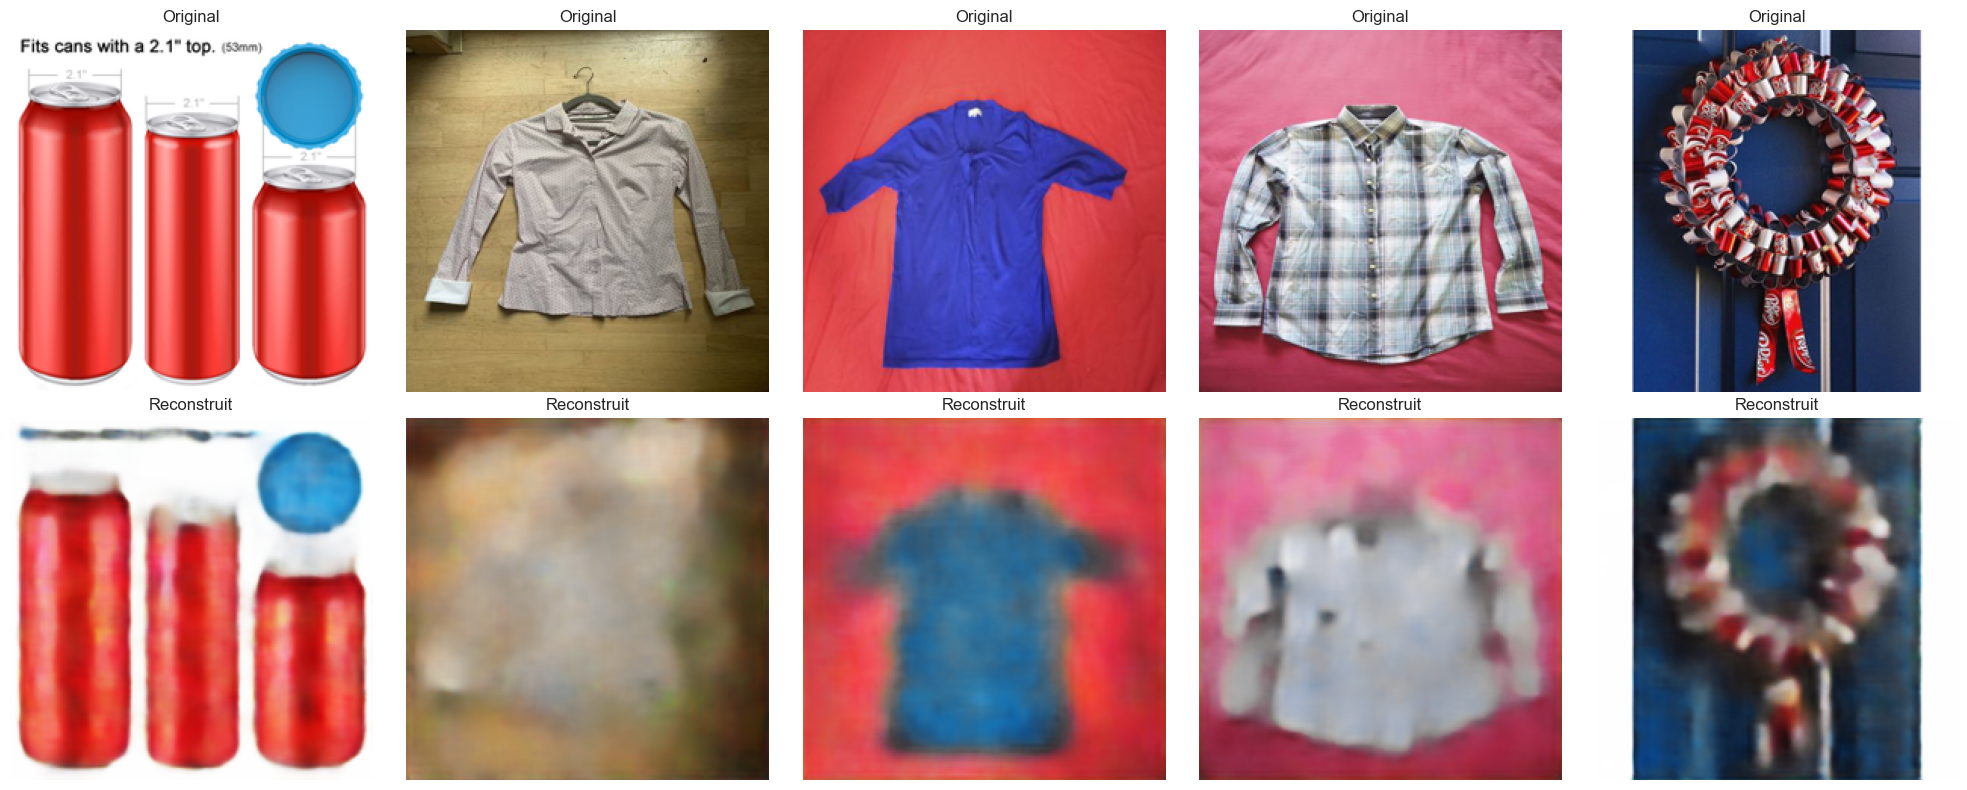

In [33]:
on_epoch_end(model,img)

In [34]:
autoencoder.save('model_dct_1.keras')

In [44]:
df_anomalie = outils.Load_data.load_object("detect_anomalie.zip")

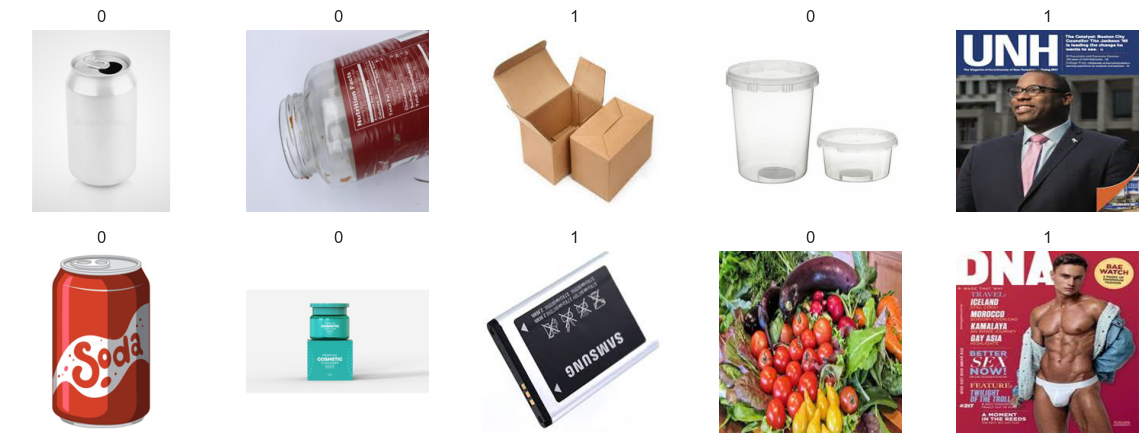

In [53]:
df_anomalie.plot(view_code=True)

In [45]:
df_anomalie.encodage()

In [48]:
(X_test_an, y_test_an), (_,_) = df_anomalie.create_data(test_size=0.0000000000001)

In [49]:
X_test_an = X_test_an.astype("float32") / 255.

In [55]:
y_test_an[6]

np.int32(0)

In [50]:
np.max(X_test_an[8])

np.float32(1.0)

In [66]:
pred = gan.discriminator.predict(X_test_an)

125/125 ━━━━━━━━━━━━━━━━━━━━ 64s 482ms/step 


In [92]:
pred

array([[0.99999976],
       [0.99999946],
       [1.        ],
       ...,
       [0.9996473 ],
       [1.        ],
       [0.99999535]], dtype=float32)

In [93]:
def f(pred):
  return pred <= 0.8

In [94]:
result = np.unique(f(pred),return_counts=True)

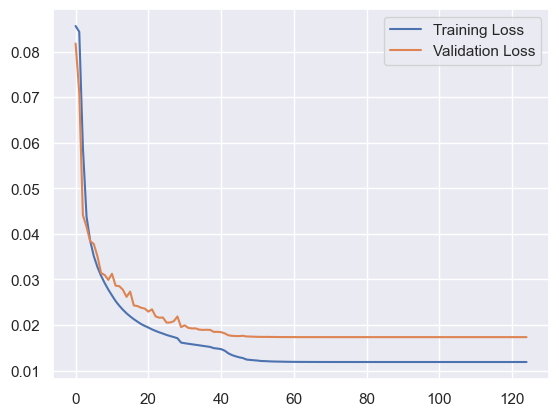

In [27]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [ ]:
# -----------------------------
# Classe ResidualVAE β-VAE
# -----------------------------
@register_keras_serializable()
class ResidualVAE(tf.keras.Model):
    def __init__(self, encoder, decoder, beta=0.001, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
    def get_config(self):
        config = super().get_config()
        config.update({
            "beta": self.beta,
            # encoder et decoder doivent aussi être sérialisés
            "encoder": tf.keras.utils.serialize_keras_object(self.encoder),
            "decoder": tf.keras.utils.serialize_keras_object(self.decoder),
        })
        return config

    @classmethod
    def from_config(cls, config):
        encoder = tf.keras.utils.deserialize_keras_object(config.pop("encoder"))
        decoder = tf.keras.utils.deserialize_keras_object(config.pop("decoder"))
        return cls(encoder=encoder, decoder=decoder, **config)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.recon_loss_tracker,
            self.kl_loss_tracker,
        ]
    def call(self, inputs):
        latent = self.encoder(inputs)
        return self.decoder(latent)
        
    def train_step(self, data):
        x = data[0] if isinstance(data, (tuple, list)) else data
        #x = tf.cast(x, tf.float32) / 255.0  # normalisation

        with tf.GradientTape() as tape:
            z_mean, z_logvar, z = self.encoder(x, training=True)
            x_hat = self.decoder(z, training=True)

            # BCE reconstruction loss
            recon_loss = tf.reduce_mean(
                tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, x_hat), axis=(1, 2))
            )

            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar), axis=1
                )
            )

            total_loss = recon_loss + self.beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        x = data[0] if isinstance(data, (tuple, list)) else data
        #x = tf.cast(x, tf.float32) / 255.0

        z_mean, z_logvar, z = self.encoder(x, training=False)
        x_hat = self.decoder(z, training=False)

        recon_loss = tf.reduce_mean(
            tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, x_hat), axis=(1, 2))
        )

        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar), axis=1)
        )

        total_loss = recon_loss + self.beta * kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def train(
        self, x_train, x_val=None, batch_size=32, epochs=100, x_vis=None, save_path="residual_vae.keras"
    ):
        self.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4))

        callbacks_list = [
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=80, restore_best_weights=True
            ),
            tf.keras.callbacks.ModelCheckpoint(save_path,monitor="recon_loss",verbose=1,save_best_only=True,mode="auto"),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss", factor=0.5, patience=10, verbose=1, min_lr=1e-7
            ),
        ]

        if x_vis is not None:
            callbacks_list.append(PlotReconstructionCallback(self, x_vis))

        history = self.fit(
            x_train, x_train,
            validation_data=(x_val, x_val) if x_val is not None else None,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks_list,
            shuffle=True,
        )
        return history
